## Importing libs


In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

## Loading Data

In [2]:
path = r'E:\ZiAd\Data Analysis Projects\Brazilian E-Commerce Dataset\Data'
geolocations = pd.read_csv(f'{path}/olist_geolocation_dataset.csv', encoding="utf-8")
orders = pd.read_csv(f'{path}/olist_orders_dataset.csv')
order_items = pd.read_csv(f'{path}/olist_order_items_dataset.csv')
orders_payments = pd.read_csv(f'{path}/olist_order_payments_dataset.csv')
products = pd.read_csv(f'{path}/olist_products_dataset.csv')
customers = pd.read_csv(f'{path}/olist_customers_dataset.csv')
reviews = pd.read_csv(f'{path}/olist_order_reviews_dataset.csv') 
sellers = pd.read_csv(f'{path}/olist_sellers_dataset.csv') 
product_category_name_translation = pd.read_csv(f'{path}/product_category_name_translation.csv') 

## Data Cleaning

#### Handling Missing Values & duplicates

##### geolocations

In [4]:
geolocations.isnull().sum()

geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

In [19]:
geolocations.duplicated().sum()

np.int64(261836)

In [21]:
geolocations.drop_duplicates(inplace=True)
geolocations.duplicated().sum()

np.int64(0)

##### orders

In [3]:
columns_to_convert = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for column in columns_to_convert:
    orders[column] = pd.to_datetime(orders[column])

In [4]:
orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [5]:
orders.loc[orders['order_delivered_customer_date'].isna(), 'order_status'].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

In [6]:
rows_to_drop = orders.loc[
    (orders['order_status'] == 'delivered') &
    (orders['order_delivered_customer_date'].isna())
].index

orders.drop(rows_to_drop, inplace=True)

In [7]:
orders.duplicated().sum()

np.int64(0)

##### order_items

In [8]:
order_items.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [23]:
order_items.duplicated().sum()

np.int64(0)

##### order_payments

In [10]:
orders_payments.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [26]:
orders_payments.duplicated().sum()

np.int64(0)

##### products

In [11]:
products.isnull().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [27]:
products.duplicated().sum()

np.int64(0)

##### customers

In [14]:
customers.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [28]:
customers.duplicated().sum()

np.int64(0)

##### reviews

In [15]:
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [30]:
reviews.duplicated().sum()

np.int64(0)

##### sellers

In [33]:
sellers.isnull().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [34]:
sellers.duplicated().sum()

np.int64(0)

### Feature Engineering

In [8]:
orders['purchase_day_of_week'] = orders['order_purchase_timestamp'].dt.day_name()

orders['purchase_hour_of_day'] = orders['order_purchase_timestamp'].dt.hour

orders['seller_handling_time_days'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.days

orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

orders['shipping_time'] = (orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']).dt.days

orders['estimated_vs_actual_delivery'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

In [9]:
order_details = order_items.groupby('order_id').agg(
    product_count=('product_id', 'nunique'),
    seller_count=('seller_id', 'nunique')
).reset_index()

orders = pd.merge(orders, order_details, on='order_id', how='left')

orders['product_count'] = orders['product_count'].fillna(0)
orders['seller_count'] = orders['seller_count'].fillna(0)

print(orders[[
    'purchase_day_of_week',
    'purchase_hour_of_day',
    'seller_handling_time_days',
    'product_count',
    'seller_count',
    'delivery_time',
    'shipping_time',
    'estimated_vs_actual_delivery'
]].head())

  purchase_day_of_week  purchase_hour_of_day  seller_handling_time_days  \
0               Monday                    10                        2.0   
1              Tuesday                    20                        0.0   
2            Wednesday                     8                        0.0   
3             Saturday                    19                        3.0   
4              Tuesday                    21                        0.0   

   product_count  seller_count  delivery_time  shipping_time  \
0            1.0           1.0            8.0            6.0   
1            1.0           1.0           13.0           12.0   
2            1.0           1.0            9.0            9.0   
3            1.0           1.0           13.0            9.0   
4            1.0           1.0            2.0            1.0   

   estimated_vs_actual_delivery  
0                          -8.0  
1                          -6.0  
2                         -18.0  
3                         -1

## Summaries & KPIs

### Sales 

##### Core Sales KPIs

In [63]:
# (Order Value) 
order_items['order_item_value'] = order_items['price'] + order_items['freight_value']

order_values = order_items.groupby('order_id')['order_item_value'].sum().reset_index()
order_values.rename(columns={'order_item_value': 'order_value'}, inplace=True)

In [64]:
# (Sales KPIs)
total_revenue = order_values['order_value'].sum()

total_orders = order_values['order_id'].nunique()

average_order_value = total_revenue / total_orders

In [65]:
print("--- Core Sales KPIs ---")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Orders: {total_orders:,}")
print(f"Average Order Value (AOV): ${average_order_value:,.2f}")

--- Core Sales KPIs ---
Total Revenue: $15,843,553.24
Total Orders: 98,666
Average Order Value (AOV): $160.58


##### Sales Trend Analysis

In [61]:
sales_trends_df = pd.merge(orders, order_values, on='order_id')
sales_trends_df.set_index('order_purchase_timestamp', inplace=True)

monthly_revenue = sales_trends_df['order_value'].resample('ME').sum()

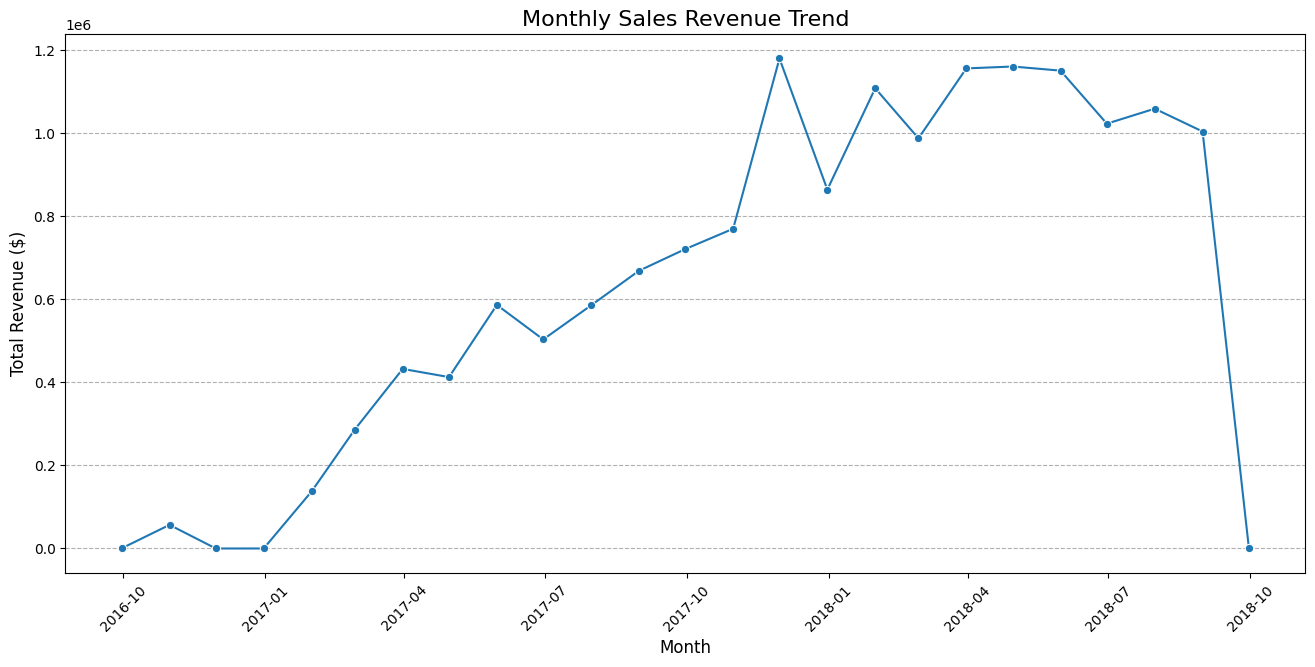

In [89]:
plt.figure(figsize=(16, 7))
sns.lineplot(x=monthly_revenue.index, y=monthly_revenue.values, marker='o')

plt.title('Monthly Sales Revenue Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

In [94]:
monthly_revenue_df = monthly_revenue.to_frame(name='revenue')
monthly_revenue_df['MoM_growth'] = monthly_revenue_df['revenue'].pct_change() * 100
monthly_revenue_df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("--- Monthly Revenue and MoM Growth ---")
print(monthly_revenue_df.to_string())

--- Monthly Revenue and MoM Growth ---
                             revenue     MoM_growth
order_purchase_timestamp                           
2016-09-30                    354.75            NaN
2016-10-31                  56808.84   15913.767442
2016-11-30                      0.00    -100.000000
2016-12-31                     19.62            NaN
2017-01-31                 137188.49  699127.777778
2017-02-28                 286280.62     108.676850
2017-03-31                 432048.59      50.917862
2017-04-30                 412422.24      -4.542626
2017-05-31                 585996.95      42.086651
2017-06-30                 502963.04     -14.169683
2017-07-31                 584971.62      16.305091
2017-08-31                 668204.60      14.228550
2017-09-30                 720398.91       7.811127
2017-10-31                 769312.37       6.789774
2017-11-30                1179008.94      53.254905
2017-12-31                 863547.23     -26.756516
2018-01-31               

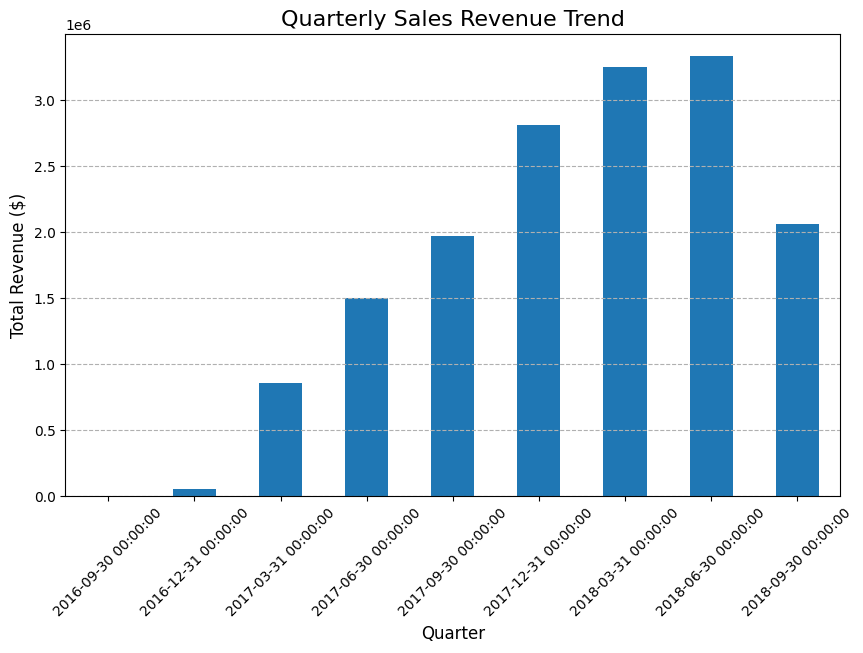

--- Quarterly Revenue Data ---
                             revenue
order_purchase_timestamp            
2016-09-30                    354.75
2016-12-31                  56828.46
2017-03-31                 855517.70
2017-06-30                1501382.23
2017-09-30                1973575.13
2017-12-31                2811868.54
2018-03-31                3249337.67
2018-06-30                3331627.64
2018-09-30                2061682.20


In [84]:
quarterly_revenue = sales_trends_df['order_value'].resample('QE').sum()

plt.figure(figsize=(10, 6))
quarterly_revenue.plot(kind='bar') 
plt.title('Quarterly Sales Revenue Trend', fontsize=16)
plt.xlabel('Quarter', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xticks(rotation=45) 
plt.grid(axis='y', linestyle='--')
plt.show()

print("--- Quarterly Revenue Data ---")
print(quarterly_revenue.to_frame(name='revenue').to_string())

##### Top/Bottom Categories Analysis        

In [63]:
product_details = pd.merge(order_items, products, on='product_id')
full_product_details = pd.merge(product_details, product_category_name_translation, on='product_category_name')

category_kpis = full_product_details.groupby('product_category_name_english').agg(
    total_revenue=('price', 'sum'),
    items_sold=('product_id', 'count')
).reset_index()

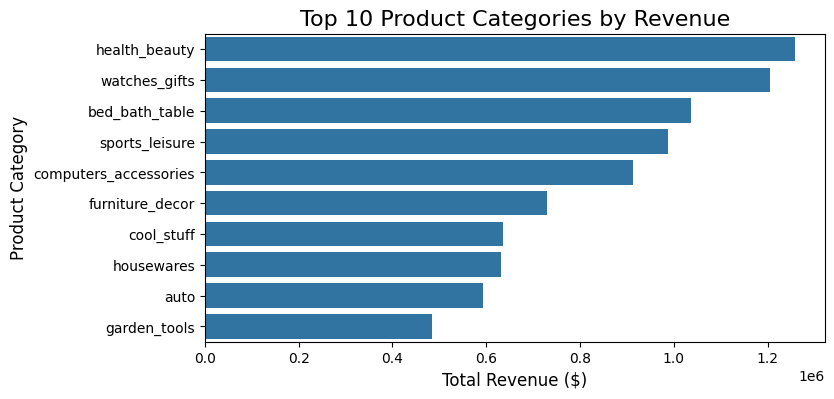

--- Top 10 Performing Categories by Revenue ---
   product_category_name_english  total_revenue  items_sold
43                 health_beauty     1258681.34        9670
70                 watches_gifts     1205005.68        5991
7                 bed_bath_table     1036988.68       11115
65                sports_leisure      988048.97        8641
15         computers_accessories      911954.32        7827
39               furniture_decor      729762.49        8334
20                    cool_stuff      635290.85        3796
49                    housewares      632248.66        6964
5                           auto      592720.11        4235
42                  garden_tools      485256.46        4347


In [67]:
top_10_categories = category_kpis.sort_values(by='total_revenue', ascending=False).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x='total_revenue', y='product_category_name_english', data=top_10_categories)
plt.title('Top 10 Product Categories by Revenue', fontsize=16)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.show()

print("--- Top 10 Performing Categories by Revenue ---")
print(top_10_categories)

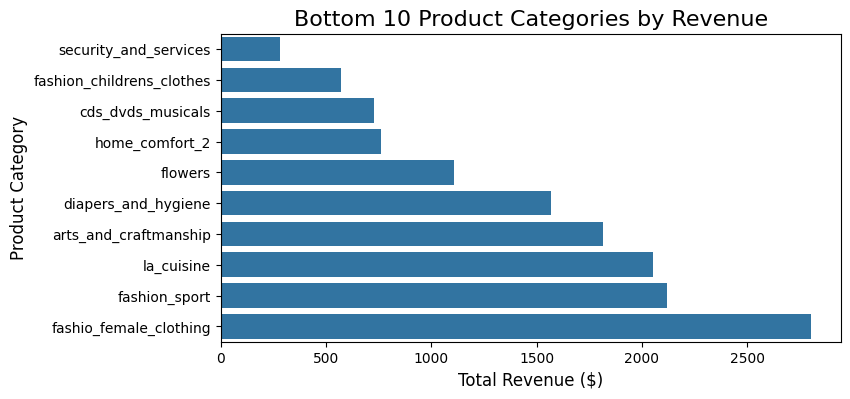


--- Bottom 10 Performing Categories by Revenue ---
   product_category_name_english  total_revenue  items_sold
61         security_and_services         283.29           2
29     fashion_childrens_clothes         569.85           8
11             cds_dvds_musicals         730.00          14
46                home_comfort_2         760.27          30
35                       flowers        1110.04          33
23           diapers_and_hygiene        1567.59          39
3          arts_and_craftmanship        1814.01          24
52                    la_cuisine        2054.99          14
32                 fashion_sport        2119.51          30
27        fashio_female_clothing        2803.64          48


In [72]:
bottom_10_categories = category_kpis.sort_values(by='total_revenue', ascending=True).head(10)

plt.figure(figsize=(8, 4))
sns.barplot(x='total_revenue', y='product_category_name_english', data=bottom_10_categories)
plt.title('Bottom 10 Product Categories by Revenue', fontsize=16)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.show()

print("\n--- Bottom 10 Performing Categories by Revenue ---")
print(bottom_10_categories)

##### Top/Bottom Products Analysis

In [77]:
product_kpis = full_product_details.groupby(['product_id', 'product_category_name_english']).agg(
    total_revenue=('price', 'sum'),
    items_sold=('order_id', 'count')
).reset_index()

top_10_products = product_kpis.sort_values(by='total_revenue', ascending=False).head(10)
print("\n--- Top 10 Performing Products by Revenue ---")
print(top_10_products.to_string())


--- Top 10 Performing Products by Revenue ---
                             product_id product_category_name_english  total_revenue  items_sold
23641  bb50f2e236e5eea0100680137654686c                 health_beauty       63885.00         195
13808  6cdd53843498f92890544667809f1595                 health_beauty       54730.20         156
27102  d6160fb7873f184099d9bc95e30376af                     computers       48899.34          35
26533  d1c427060a0f73f6b889a5c7c61f2ac4         computers_accessories       47214.51         343
19387  99a4788cb24856965c36a24e339b6058                bed_bath_table       43025.56         488
7902   3dd2a17168ec895c781a9191c1e95ad7         computers_accessories       41082.60         274
4901   25c38557cf793876c5abdd5931f922db                          baby       38907.32          38
12125  5f504b3a1c75b73d6151be81eb05bdc9                    cool_stuff       37733.90          63
10662  53b36df67ebb7c41585e8d54d6772e08                 watches_gifts       3768

In [74]:
bottom_10_products = product_kpis.sort_values(by='total_revenue', ascending=True).head(10)
print("\n--- Bottom 10 Performing Products by Revenue ---")
print(bottom_10_products.to_string())


--- Bottom 10 Performing Products by Revenue ---
                             product_id    product_category_name_english  total_revenue  items_sold
9061   46fce52cef5caa7cc225a5531c946c8b                    health_beauty           2.20           1
6266   310dc32058903b6416c71faff132df9e                       stationery           2.29           1
17448  8a3254bee785a526d548a81a9bc3c9be  construction_tools_construction           2.55           3
13213  680cc8535be7cc69544238c1d6a83fe8                         pet_shop           2.90           1
5966   2e8316b31db34314f393806fd7b6e185                       stationery           2.99           1
10578  5304ff3fa35856a156e1170a6022d34d                              art           3.50           1
1917   0eeeb45e2f5911fd44282e5bb0c624ff                            music           3.85           1
24588  c2fb26742f8484dbfe9a8d70bdc54025            computers_accessories           3.90           1
30179  eee2fb3dceb9ffd8a99dd4bc4b7e860a           

### Customer 

#### Unique Customers

In [95]:
unique_customers_count = customers['customer_unique_id'].nunique()
print("--- Customer KPIs ---")
print(f"Total Unique Customers: {unique_customers_count:,}")

--- Customer KPIs ---
Total Unique Customers: 96,096


#### Repeat Customers

In [96]:
customer_orders_df = pd.merge(orders, customers, on='customer_id')

order_counts_per_customer = customer_orders_df['customer_unique_id'].value_counts()

repeat_customers_count = order_counts_per_customer[order_counts_per_customer > 1].count()
repeat_customer_percentage = (repeat_customers_count / unique_customers_count) * 100

print(f"Number of Repeat Customers: {repeat_customers_count:,}")
print(f"Percentage of Repeat Customers: {repeat_customer_percentage:.2f}%")

Number of Repeat Customers: 2,997
Percentage of Repeat Customers: 3.12%


#### Customer Lifetime Value - CLV)

In [97]:
clv_df = pd.merge(customer_orders_df, order_values, on='order_id')

customer_lifetime_value = clv_df.groupby('customer_unique_id')['order_value'].sum().reset_index()
customer_lifetime_value.rename(columns={'order_value': 'total_spent'}, inplace=True)

top_10_customers = customer_lifetime_value.sort_values(by='total_spent', ascending=False).head(10)

print("--- Top 10 Most Valuable Customers (by Total Spending) ---")
print(top_10_customers.to_string())

--- Top 10 Most Valuable Customers (by Total Spending) ---
                     customer_unique_id  total_spent
3799   0a0a92112bd4c708ca5fde585afaa872     13664.08
81381  da122df9eeddfedc1dc1f5349a1a690c      7571.63
44134  763c8b1c9c68a0229c42c9fc6f662b93      7274.88
82223  dc4802a71eae9be1dd28f5d788ceb526      6929.31
26010  459bef486812aa25204be022145caa62      6922.21
95123  ff4159b92c40ebe40454e3e6a7c35ed6      6726.66
23942  4007669dec559734d6f53e029e360987      6081.54
34815  5d0a2980b292d049061542014e8960bf      4809.44
89048  eebb5dda148d3893cdaf5b5ca3040ccb      4764.34
27237  48e1ac109decbb87765a3eade6854098      4681.78


#### Top States

In [99]:
top_10_states = customers['customer_state'].value_counts().head(10)

print("--- Top 10 States by Customer Count ---")
print(top_10_states)

--- Top 10 States by Customer Count ---
customer_state
SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
Name: count, dtype: int64


#### Top Cities

In [100]:
top_10_cities = customers['customer_city'].value_counts().head(10)

print("--- Top 10 Cities by Customer Count ---")
print(top_10_cities)

--- Top 10 Cities by Customer Count ---
customer_city
sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
Name: count, dtype: int64


#### Purchases by Day of the Week

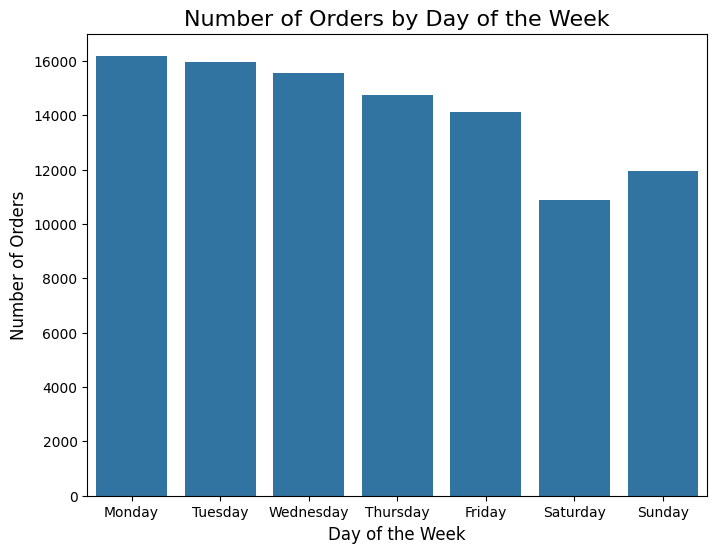

In [110]:
plt.figure(figsize=(8, 6))
sns.countplot(x='purchase_day_of_week', data=orders, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Orders by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()

#### Purchases by Hour of the Day

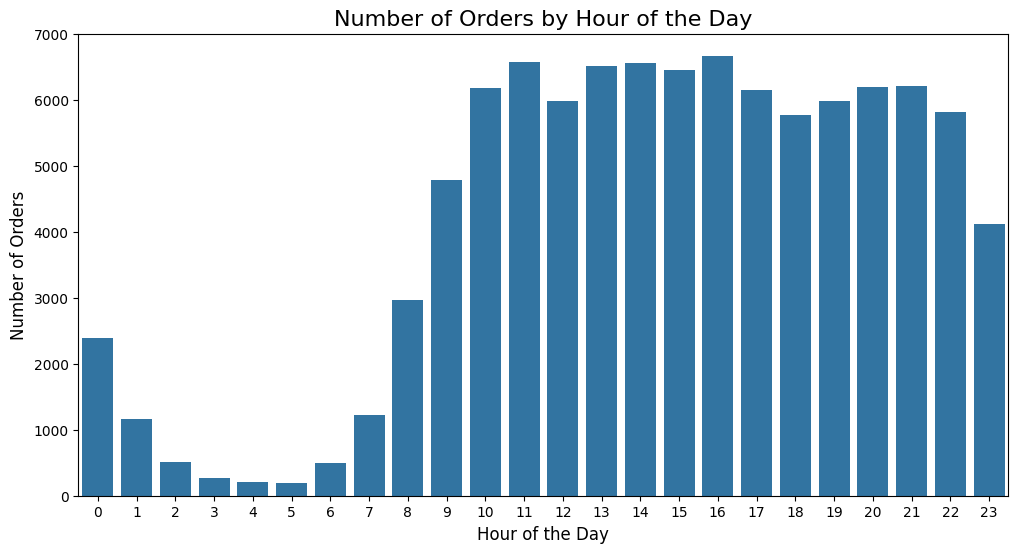

In [105]:
plt.figure(figsize=(12, 6))
sns.countplot(x='purchase_hour_of_day', data=orders)
plt.title('Number of Orders by Hour of the Day', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()

### Seller 

#### Total Sellers

In [11]:
total_sellers = order_items['seller_id'].nunique()
print(f"Total Unique Sellers: {total_sellers:,}")

Total Unique Sellers: 3,095


#### Top 10 Sellers by Total Revenue

In [14]:
seller_revenue = order_items.groupby('seller_id')['price'].sum().reset_index()
seller_revenue.rename(columns={'price': 'total_revenue'}, inplace=True)
top_10_sellers_revenue = seller_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print("--- Top 10 Sellers by Total Revenue ---")
print(top_10_sellers_revenue.to_string())

--- Top 10 Sellers by Total Revenue ---
                             seller_id  total_revenue
857   4869f7a5dfa277a7dca6462dcf3b52b2      229472.63
1013  53243585a1d6dc2643021fd1853d8905      222776.05
881   4a3ca9315b744ce9f8e9374361493884      200472.92
3024  fa1c13f2614d7b5c4749cbc52fecda94      194042.03
1535  7c67e1448b00f6e969d365cea6b010ab      187923.89
1560  7e93a43ef30c4f03f38b393420bc753a      176431.87
2643  da8622b14eb17ae2831f4ac5b9dab84a      160236.57
1505  7a67c85e85bb2ce8582c35f2203ad736      141745.53
192   1025f0e2d44d7041d6cf58b6550e0bfa      138968.55
1824  955fee9216a65b617aa5c0531780ce60      135171.70


#### Top 10 Sellers by Number of Orders

In [15]:
seller_orders = order_items.groupby('seller_id')['order_id'].nunique().reset_index()
seller_orders.rename(columns={'order_id': 'total_orders'}, inplace=True)
top_10_sellers_orders = seller_orders.sort_values(by='total_orders', ascending=False).head(10)
print("--- Top 10 Sellers by Number of Orders ---")
print(top_10_sellers_orders.to_string())

--- Top 10 Sellers by Number of Orders ---
                             seller_id  total_orders
1235  6560211a19b47992c3666cc44a7e94c0          1854
881   4a3ca9315b744ce9f8e9374361493884          1806
2481  cc419e0650a3c5ba77189a1882b7556a          1706
368   1f50f920176fa81dab994f9023523100          1404
2643  da8622b14eb17ae2831f4ac5b9dab84a          1314
1824  955fee9216a65b617aa5c0531780ce60          1287
1505  7a67c85e85bb2ce8582c35f2203ad736          1160
2836  ea8482cd71df3c1969d7b9473ff13abc          1146
857   4869f7a5dfa277a7dca6462dcf3b52b2          1132
731   3d871de0142ce09b7081e2b9d1733cb1          1080


#### Seller Handling Time

In [16]:
seller_handling_df = pd.merge(orders, order_items, on='order_id')
avg_handling_time = seller_handling_df.groupby('seller_id')['seller_handling_time_days'].mean().reset_index()
avg_handling_time.rename(columns={'seller_handling_time_days': 'avg_handling_days'}, inplace=True)
fastest_sellers = avg_handling_time.sort_values(by='avg_handling_days', ascending=True).head(10)

print("--- Top 10 Fastest Sellers (by Average Handling Time in Days) ---")
print(fastest_sellers.to_string())

--- Top 10 Fastest Sellers (by Average Handling Time in Days) ---
                             seller_id  avg_handling_days
1688  89de2d6f23e9746ff309705b23581faa            -18.375
1844  96e5dc09087bad639b4ee193104ec2e5             -3.000
245   154bdf805377afea75a3bd158e9eab10             -2.000
1030  544863df86ed3b78a04e0820d41430ee             -2.000
2240  babcc0ab201e4c60188427cae51a5b8b             -2.000
2185  b5d034ac251546e25afe9067f05c1539             -1.000
2462  cad10cc982ab6a391570c211b995c17c             -1.000
373   1fa2d3def6adfa70e58c276bb64fe5bb             -1.000
2131  b19c48688808720822399ffa9f2dbe2f             -1.000
2963  f4ce8ca9fa7157e3b33f536ac9a4487d             -1.000


#### Overall Top 10 Sellers

In [17]:
seller_summary = pd.merge(seller_revenue, seller_orders, on='seller_id')
seller_summary = pd.merge(seller_summary, avg_handling_time, on='seller_id')
top_10_sellers_summary = seller_summary.sort_values(by='total_revenue', ascending=False).head(10)

print("--- Overall Top 10 Sellers ---")
print(top_10_sellers_summary.to_string())

--- Overall Top 10 Sellers ---
                             seller_id  total_revenue  total_orders  avg_handling_days
857   4869f7a5dfa277a7dca6462dcf3b52b2      229472.63          1132           1.806926
1013  53243585a1d6dc2643021fd1853d8905      222776.05           358           2.678218
881   4a3ca9315b744ce9f8e9374361493884      200472.92          1806           1.849446
3024  fa1c13f2614d7b5c4749cbc52fecda94      194042.03           585           1.837050
1535  7c67e1448b00f6e969d365cea6b010ab      187923.89           982          11.078561
1560  7e93a43ef30c4f03f38b393420bc753a      176431.87           336           1.908257
2643  da8622b14eb17ae2831f4ac5b9dab84a      160236.57          1314           1.776918
1505  7a67c85e85bb2ce8582c35f2203ad736      141745.53          1160           1.088260
192   1025f0e2d44d7041d6cf58b6550e0bfa      138968.55           915           3.193978
1824  955fee9216a65b617aa5c0531780ce60      135171.70          1287           1.217101


### Logistics 

#### Core Logistics KPIs

In [21]:
avg_delivery_time = orders['delivery_time'].mean()
avg_shipping_time = orders['shipping_time'].mean()
avg_estimated_vs_actual = orders['estimated_vs_actual_delivery'].mean()

print("--- Core Logistics KPIs ---")
print(f"Average Total Delivery Time: {avg_delivery_time:.2f} days")
print(f"Average Shipping Time (Carrier): {avg_shipping_time:.2f} days")
print(f"Average Estimated vs. Actual Delivery: {avg_estimated_vs_actual:.2f} days")

--- Core Logistics KPIs ---
Average Total Delivery Time: 12.09 days
Average Shipping Time (Carrier): 8.88 days
Average Estimated vs. Actual Delivery: -11.88 days


#### Late Orders %

In [23]:
orders['is_late'] = orders['estimated_vs_actual_delivery'] > 0

late_orders_count = orders['is_late'].sum()
total_delivered_orders = orders['order_delivered_customer_date'].notna().sum()
late_orders_percentage = (late_orders_count / total_delivered_orders) * 100
print(f"Percentage of Late Orders: {late_orders_percentage:.2f}%")

Percentage of Late Orders: 6.77%


#### Delivery Time Distribution

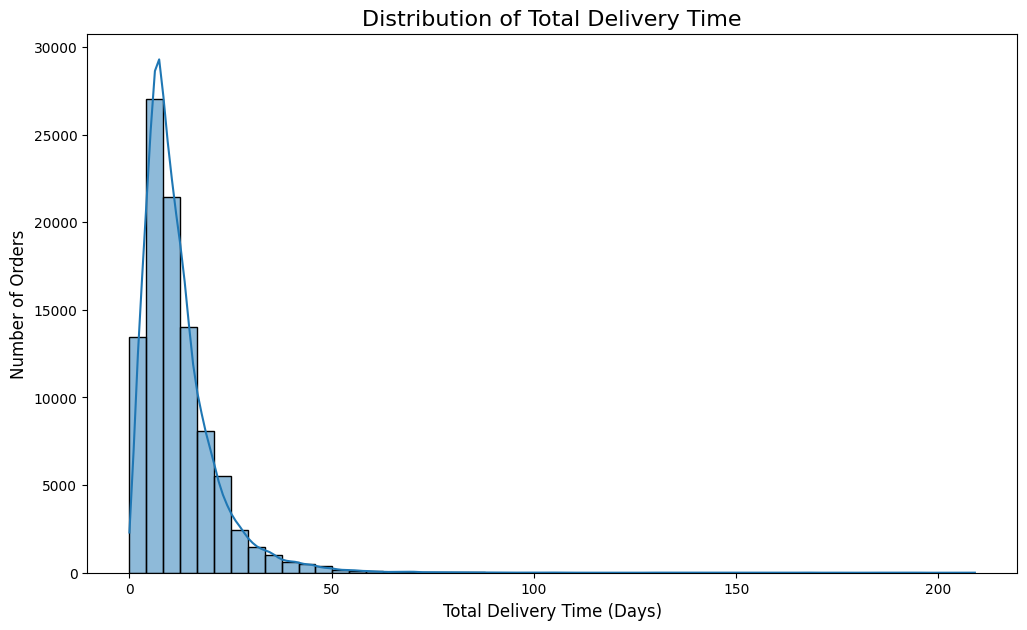

In [24]:
plt.figure(figsize=(12, 7))
sns.histplot(data=orders, x='delivery_time', bins=50, kde=True) 
plt.title('Distribution of Total Delivery Time', fontsize=16)
plt.xlabel('Total Delivery Time (Days)', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()

#### Top 10 States by Delayed Order Count

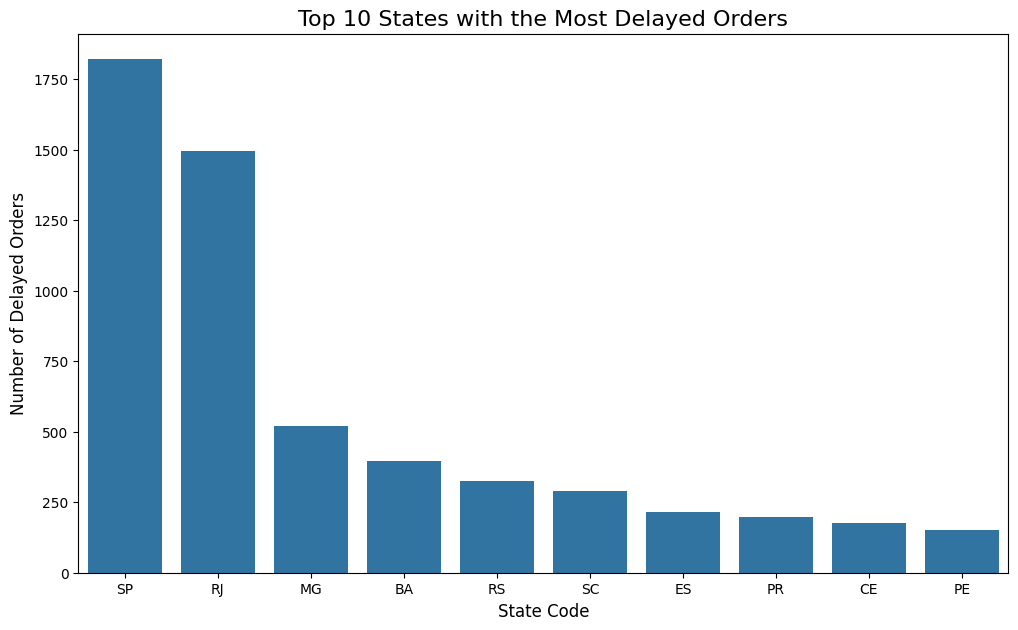

--- Top 10 States by Delayed Order Count ---
customer_state
SP    1820
RJ    1495
MG     520
BA     396
RS     325
SC     291
ES     214
PR     199
CE     176
PE     153
Name: count, dtype: int64


In [27]:
late_orders = orders[orders['is_late'] == True]
late_orders_geo = pd.merge(late_orders, customers, on='customer_id')

top_10_late_states = late_orders_geo['customer_state'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_10_late_states.index, y=top_10_late_states.values)
plt.title('Top 10 States with the Most Delayed Orders', fontsize=16)
plt.xlabel('State Code', fontsize=12)
plt.ylabel('Number of Delayed Orders', fontsize=12)
plt.show()

print("--- Top 10 States by Delayed Order Count ---")
print(top_10_late_states)

#### Top 10 States by Late Order Rate

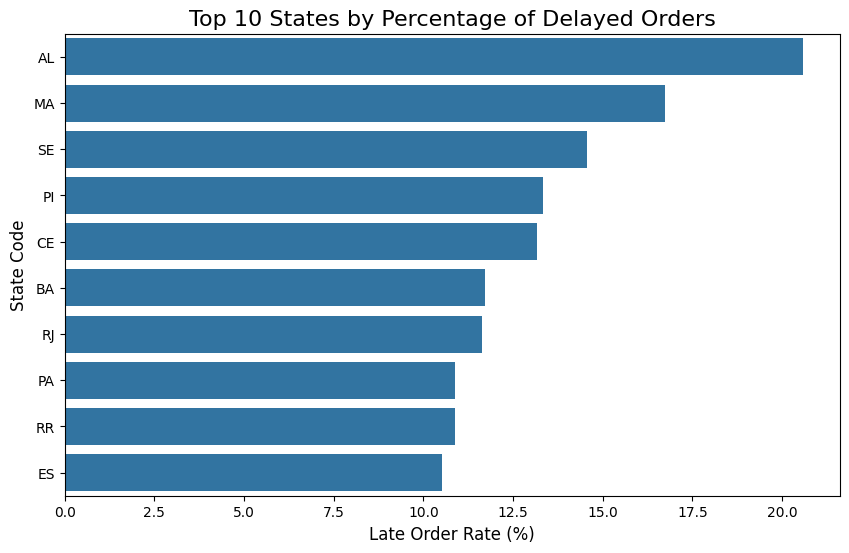

--- Top 10 States by Late Order Rate ---
   customer_state  total_orders  late_orders  late_order_rate
1              AL           413           85        20.581114
9              MA           747          125        16.733601
24             SE           350           51        14.571429
16             PI           495           66        13.333333
5              CE          1336          176        13.173653
4              BA          3380          396        11.715976
18             RJ         12852         1495        11.632431
13             PA           975          106        10.871795
21             RR            46            5        10.869565
7              ES          2033          214        10.526316


In [29]:
orders_with_geo = pd.merge(orders, customers, on='customer_id')
state_performance = orders_with_geo.groupby('customer_state').agg(
    total_orders=('order_id', 'count'),
    late_orders=('is_late', 'sum') # 'is_late' is boolean (True=1, False=0), so sum() counts the late ones
).reset_index()

state_performance['late_order_rate'] = (state_performance['late_orders'] / state_performance['total_orders']) * 100
top_10_late_rate_states = state_performance.sort_values(by='late_order_rate', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='late_order_rate', y='customer_state', data=top_10_late_rate_states)
plt.title('Top 10 States by Percentage of Delayed Orders', fontsize=16)
plt.xlabel('Late Order Rate (%)', fontsize=12)
plt.ylabel('State Code', fontsize=12)
plt.show()

print("--- Top 10 States by Late Order Rate ---")
print(top_10_late_rate_states)

### Payment 

#### Payment Methods Distribution

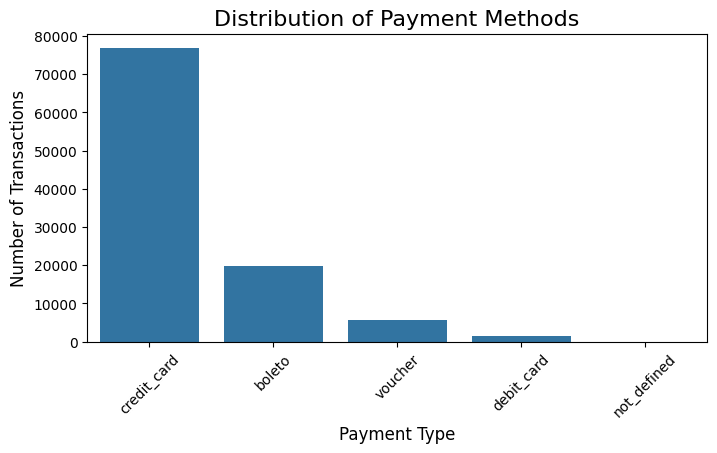

--- Payment Methods Distribution ---
payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64


In [32]:
payment_distribution = orders_payments['payment_type'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=payment_distribution.index, y=payment_distribution.values)
plt.title('Distribution of Payment Methods', fontsize=16)
plt.xlabel('Payment Type', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=45)
plt.show()

print("--- Payment Methods Distribution ---")
print(payment_distribution)

#### Total Payment Value by Payment Type

In [35]:
value_per_payment_type = orders_payments.groupby('payment_type')['payment_value'].sum().sort_values(ascending=False)
print("--- Total Payment Value by Payment Type ---")
print(value_per_payment_type)

--- Total Payment Value by Payment Type ---
payment_type
credit_card    12542084.19
boleto          2869361.27
voucher          379436.87
debit_card       217989.79
not_defined           0.00
Name: payment_value, dtype: float64


#### Distribution of Installments

In [40]:
credit_card_payments = orders_payments[orders_payments['payment_type'] == 'credit_card']
avg_installments = credit_card_payments['payment_installments'].mean()

print("--- Installment KPIs (for Credit Card payments) ---")
print(f"Average number of installments: {avg_installments:.2f}")

--- Installment KPIs (for Credit Card payments) ---
Average number of installments: 3.51


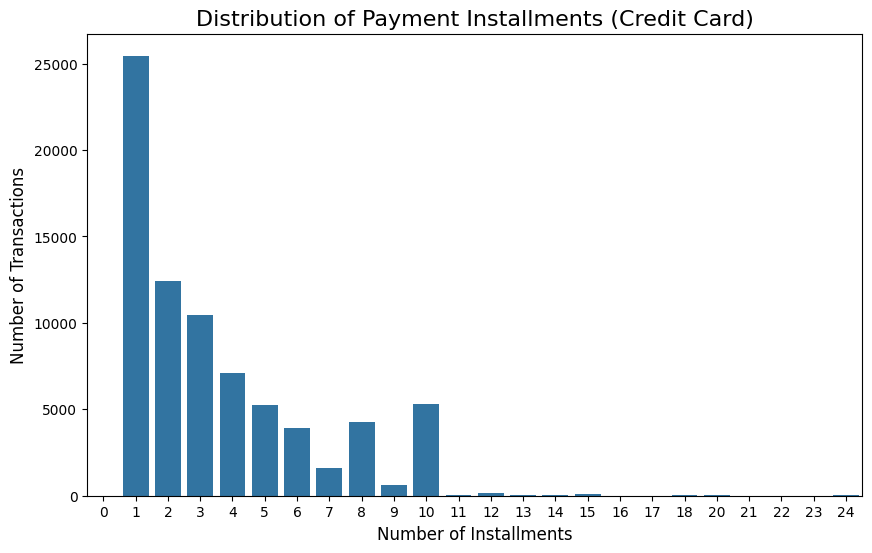


--- Distribution of Installments ---
payment_installments
0         2
1     25455
2     12413
3     10461
4      7098
5      5239
6      3920
7      1626
8      4268
9       644
10     5328
11       23
12      133
13       16
14       15
15       74
16        5
17        8
18       27
20       17
21        3
22        1
23        1
24       18
Name: count, dtype: int64


In [42]:
installments_distribution = credit_card_payments['payment_installments'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=installments_distribution.index, y=installments_distribution.values)
plt.title('Distribution of Payment Installments (Credit Card)', fontsize=16)
plt.xlabel('Number of Installments', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.show()

print("\n--- Distribution of Installments ---")
print(installments_distribution)

#### Electronic vs. Cash/Voucher Payment Ratio

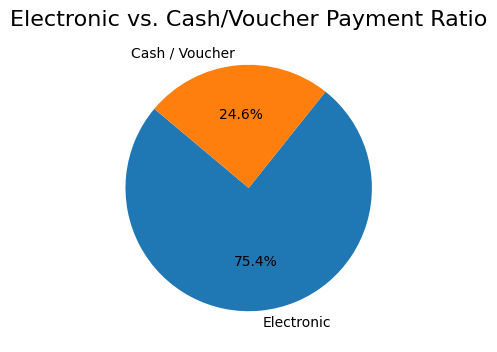

--- Payment Category Distribution ---
payment_category
Electronic        78324
Cash / Voucher    25562
Name: count, dtype: int64


In [50]:
def classify_payment(payment_type):
    if payment_type in ['credit_card', 'debit_card']:
        return 'Electronic'
    else: 
        return 'Cash / Voucher'

orders_payments['payment_category'] = orders_payments['payment_type'].apply(classify_payment)
payment_category_dist = orders_payments['payment_category'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(payment_category_dist, labels=payment_category_dist.index, autopct='%1.1f%%', startangle=140)
plt.title('Electronic vs. Cash/Voucher Payment Ratio', fontsize=16)
plt.ylabel('') # Hide the y-label as it's not needed for a pie chart
plt.show()

print("--- Payment Category Distribution ---")
print(payment_category_dist)

### Review 

#### Review Score

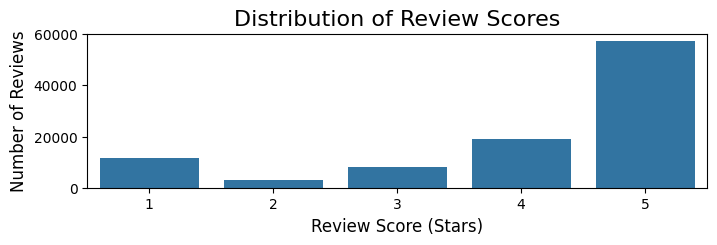

--- Review Score Distribution ---
review_score
1    11424
2     3151
3     8179
4    19142
5    57328
Name: count, dtype: int64


In [55]:
score_distribution = reviews['review_score'].value_counts().sort_index()

plt.figure(figsize=(8, 2))
sns.barplot(x=score_distribution.index, y=score_distribution.values)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Review Score (Stars)', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

print("--- Review Score Distribution ---")
print(score_distribution)

In [56]:
average_score = reviews['review_score'].mean()

print("--- Average Review Score ---")
print(f"The overall average review score is: {average_score:.2f} out of 5")

--- Average Review Score ---
The overall average review score is: 4.09 out of 5


#### Average Delivery Time per Review Score

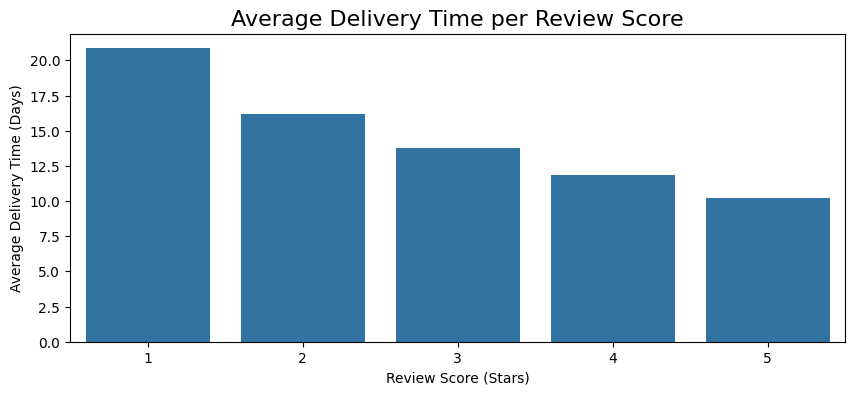

--- Average Delivery Time per Review Score ---
   review_score  delivery_time
0             1      20.850462
1             2      16.195512
2             3      13.796031
3             4      11.848423
4             5      10.224430


In [60]:
reviews_with_delivery = pd.merge(reviews, orders, on='order_id')
avg_delivery_per_score = reviews_with_delivery.groupby('review_score')['delivery_time'].mean().reset_index()

plt.figure(figsize=(10, 4))
sns.barplot(x='review_score', y='delivery_time', data=avg_delivery_per_score)
plt.title('Average Delivery Time per Review Score', fontsize=16)
plt.xlabel('Review Score (Stars)', fontsize=10)
plt.ylabel('Average Delivery Time (Days)', fontsize=10)
plt.show()

print("--- Average Delivery Time per Review Score ---")
print(avg_delivery_per_score)

#### Top Positive vs Negative Categories

In [61]:
reviews_items = pd.merge(reviews, order_items, on='order_id')
reviews_products = pd.merge(reviews_items, products, on='product_id')
full_review_details = pd.merge(reviews_products, product_category_name_translation, on='product_category_name')

avg_score_per_category = full_review_details.groupby('product_category_name_english')['review_score'].mean().reset_index()

top_rated_categories = avg_score_per_category.sort_values(by='review_score', ascending=False).head(10)
print("--- Top 10 Best Rated Product Categories ---")
print(top_rated_categories.to_string())

bottom_rated_categories = avg_score_per_category.sort_values(by='review_score', ascending=True).head(10)
print("\n--- Bottom 10 Worst Rated Product Categories ---")
print(bottom_rated_categories.to_string())

--- Top 10 Best Rated Product Categories ---
            product_category_name_english  review_score
11                      cds_dvds_musicals      4.642857
29              fashion_childrens_clothes      4.500000
8                  books_general_interest      4.446266
22                costruction_tools_tools      4.444444
35                                flowers      4.419355
9                          books_imported      4.400000
10                        books_technical      4.368421
37                             food_drink      4.315412
53                    luggage_accessories      4.315257
64  small_appliances_home_oven_and_coffee      4.302632

--- Bottom 10 Worst Rated Product Categories ---
        product_category_name_english  review_score
61              security_and_services      2.500000
23                diapers_and_hygiene      3.256410
57                   office_furniture      3.493183
46                     home_comfort_2      3.629630
30              fashion_male_

### Customer Segmentation using RFM

In [74]:
rfm_base_df = pd.merge(customers, orders, on='customer_id')
rfm_base_df = pd.merge(rfm_base_df, order_values, on='order_id')

snapshot_date = rfm_base_df['order_purchase_timestamp'].max() + dt.timedelta(days=1)
recency_df = rfm_base_df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency_df['recency'] = (snapshot_date - recency_df['order_purchase_timestamp']).dt.days

frequency_df = rfm_base_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
frequency_df.rename(columns={'order_id': 'frequency'}, inplace=True)

monetary_df = rfm_base_df.groupby('customer_unique_id')['order_value'].sum().reset_index()
monetary_df.rename(columns={'order_value': 'monetary'}, inplace=True)

rfm_df = pd.merge(recency_df[['customer_unique_id', 'recency']], frequency_df, on='customer_unique_id')
rfm_df = pd.merge(rfm_df, monetary_df, on='customer_unique_id')

In [73]:
rfm_df['R_Score'] = pd.qcut(rfm_df['recency'], q=4, labels=[4, 3, 2, 1]).astype(int)
rfm_df['F_Score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)

rfm_df['RFM_Score'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']

print("---  RFM Scores Calculated ---")
print(rfm_df[['customer_unique_id', 'recency', 'frequency', 'monetary', 'RFM_Score']].head())

---  RFM Scores Calculated ---
                 customer_unique_id  recency  frequency  monetary  RFM_Score
0  0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90          8
1  0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19          6
2  0000f46a3911fa3c0805444483337064      542          1     86.22          4
3  0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62          4
4  0004aac84e0df4da2b147fca70cf8255      293          1    196.89          7


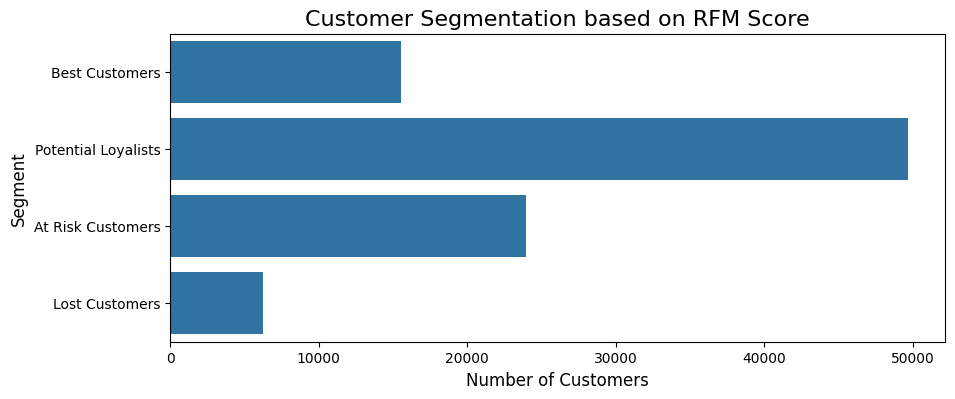

--- Analysis of Customer Segments ---
                     customer_count  avg_recency  avg_frequency  avg_monetary  \
RFM_Segment_Name                                                                
Best Customers                15540   120.220785       1.142921    294.295163   
Potential Loyalists           49683   221.624741       1.020269    174.093355   
At Risk Customers             23938   324.354290       1.000752     95.379275   
Lost Customers                 6251   415.865462       1.000000     53.776713   

                     avg_RFM_Score  
RFM_Segment_Name                    
Best Customers           10.535521  
Potential Loyalists       7.932895  
At Risk Customers         5.617595  
Lost Customers            3.751400  


In [79]:
def assign_segment_name(score):
    if score >= 10:
        return 'Best Customers' 
    elif score >= 7:
        return 'Potential Loyalists'
    elif score >= 5:
        return 'At Risk Customers'
    else:
        return 'Lost Customers'


rfm_df['RFM_Segment_Name'] = rfm_df['RFM_Score'].apply(assign_segment_name)

segment_analysis = rfm_df.groupby('RFM_Segment_Name').agg(
    customer_count=('customer_unique_id', 'count'),
    avg_recency=('recency', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_monetary=('monetary', 'mean'),
    avg_RFM_Score=('RFM_Score', 'mean')
).sort_values(by='avg_RFM_Score', ascending=False)

plt.figure(figsize=(10, 4))
sns.countplot(y='RFM_Segment_Name', data=rfm_df, order=segment_analysis.index)
plt.title('Customer Segmentation based on RFM Score', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Segment', fontsize=12)
plt.show()

print("--- Analysis of Customer Segments ---")
print(segment_analysis)

## Export 

In [2]:
## Importing libs
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import warnings
warnings.filterwarnings('ignore')

## Loading Data from original path
original_path = r'E:\ZiAd\Data Analysis Projects\Brazilian E-Commerce Dataset\Data'

print("🔄 Loading original datasets...")

# Load all original datasets
geolocations = pd.read_csv(f'{original_path}/olist_geolocation_dataset.csv', encoding="utf-8")
orders = pd.read_csv(f'{original_path}/olist_orders_dataset.csv')
order_items = pd.read_csv(f'{original_path}/olist_order_items_dataset.csv')
orders_payments = pd.read_csv(f'{original_path}/olist_order_payments_dataset.csv')
products = pd.read_csv(f'{original_path}/olist_products_dataset.csv')
customers = pd.read_csv(f'{original_path}/olist_customers_dataset.csv')
reviews = pd.read_csv(f'{original_path}/olist_order_reviews_dataset.csv') 
sellers = pd.read_csv(f'{original_path}/olist_sellers_dataset.csv') 
product_category_name_translation = pd.read_csv(f'{original_path}/product_category_name_translation.csv')

print("✅ All datasets loaded successfully!")

## Data Cleaning (same as your original code)
print("🧹 Cleaning data...")

# Clean geolocations
geolocations.drop_duplicates(inplace=True)

# Clean orders and convert datetime columns
columns_to_convert = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for column in columns_to_convert:
    orders[column] = pd.to_datetime(orders[column])

# Remove inconsistent delivered orders
rows_to_drop = orders.loc[
    (orders['order_status'] == 'delivered') &
    (orders['order_delivered_customer_date'].isna())
].index
orders.drop(rows_to_drop, inplace=True)

## Feature Engineering (same as your original code)
print("⚙️ Creating features...")

# Add time-based features
orders['purchase_day_of_week'] = orders['order_purchase_timestamp'].dt.day_name()
orders['purchase_hour_of_day'] = orders['order_purchase_timestamp'].dt.hour
orders['seller_handling_time_days'] = (orders['order_delivered_carrier_date'] - orders['order_approved_at']).dt.days
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days
orders['shipping_time'] = (orders['order_delivered_customer_date'] - orders['order_delivered_carrier_date']).dt.days
orders['estimated_vs_actual_delivery'] = (orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']).dt.days

# Add order details
order_details = order_items.groupby('order_id').agg(
    product_count=('product_id', 'nunique'),
    seller_count=('seller_id', 'nunique')
).reset_index()

orders = pd.merge(orders, order_details, on='order_id', how='left')
orders['product_count'] = orders['product_count'].fillna(0)
orders['seller_count'] = orders['seller_count'].fillna(0)

# Add late order indicator
orders['is_late'] = orders['estimated_vs_actual_delivery'] > 0

# Calculate order values
order_items['order_item_value'] = order_items['price'] + order_items['freight_value']
order_values = order_items.groupby('order_id')['order_item_value'].sum().reset_index()
order_values.rename(columns={'order_item_value': 'order_value'}, inplace=True)

# Create enhanced product details
product_details = pd.merge(order_items, products, on='product_id')
full_product_details = pd.merge(product_details, product_category_name_translation, on='product_category_name')

print("✅ Feature engineering completed!")

## Output directory setup
output_path = r'E:\ZiAd\Data Analysis Projects\Brazilian E-Commerce Dataset\DashBoard\Files'

# Create directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print(f"📁 Created directory: {output_path}")

def save_to_csv(df, filename, description=""):
    """Save dataframe to CSV with proper formatting for Tableau"""
    full_path = os.path.join(output_path, filename)
    df.to_csv(full_path, index=False, encoding='utf-8')
    print(f"✅ Created: {filename} ({len(df):,} rows) - {description}")

## 1. ORDERS ENHANCED (Main fact table)
print("\n📊 Creating Orders Enhanced dataset...")

orders_enhanced = orders.copy()

# Add customer info
orders_enhanced = pd.merge(orders_enhanced, customers, on='customer_id', how='left')

# Add order values
orders_enhanced = pd.merge(orders_enhanced, order_values, on='order_id', how='left')

# Add payment info (summarized per order)
payment_summary = orders_payments.groupby('order_id').agg({
    'payment_value': 'sum',
    'payment_installments': 'max',
    'payment_type': lambda x: x.mode().iloc[0] if not x.mode().empty else 'unknown'
}).reset_index()
payment_summary.columns = ['order_id', 'total_payment_value', 'max_installments', 'primary_payment_type']

orders_enhanced = pd.merge(orders_enhanced, payment_summary, on='order_id', how='left')

# Add review scores
review_summary = reviews.groupby('order_id')['review_score'].mean().reset_index()
orders_enhanced = pd.merge(orders_enhanced, review_summary, on='order_id', how='left')

# Add time dimensions for Tableau
orders_enhanced['Year'] = orders_enhanced['order_purchase_timestamp'].dt.year
orders_enhanced['Month'] = orders_enhanced['order_purchase_timestamp'].dt.month
orders_enhanced['Month_Name'] = orders_enhanced['order_purchase_timestamp'].dt.strftime('%B')
orders_enhanced['Quarter'] = orders_enhanced['order_purchase_timestamp'].dt.quarter
orders_enhanced['Day_of_Year'] = orders_enhanced['order_purchase_timestamp'].dt.dayofyear
orders_enhanced['Week_of_Year'] = orders_enhanced['order_purchase_timestamp'].dt.isocalendar().week
orders_enhanced['Year_Month'] = orders_enhanced['order_purchase_timestamp'].dt.strftime('%Y-%m')
orders_enhanced['Year_Quarter'] = orders_enhanced['order_purchase_timestamp'].dt.strftime('%Y-Q') + orders_enhanced['Quarter'].astype(str)

save_to_csv(orders_enhanced, 'orders_enhanced.csv', 'Main fact table with all dimensions')

## 2. SALES SUMMARY DATA
print("\n💰 Creating Sales Summary dataset...")

# Create sales trends dataframe
sales_trends_df = pd.merge(orders, order_values, on='order_id')

# Monthly sales data
monthly_sales = sales_trends_df.set_index('order_purchase_timestamp').resample('ME').agg({
    'order_value': ['sum', 'count', 'mean']
}).round(2)

monthly_sales.columns = ['Total_Revenue', 'Total_Orders', 'AOV']
monthly_sales['Year_Month'] = monthly_sales.index.strftime('%Y-%m')
monthly_sales['Month_Name'] = monthly_sales.index.strftime('%B %Y')
monthly_sales['Year'] = monthly_sales.index.year
monthly_sales['Month'] = monthly_sales.index.month
monthly_sales = monthly_sales.reset_index()

# Add MoM growth
monthly_sales['Revenue_MoM_Growth'] = monthly_sales['Total_Revenue'].pct_change() * 100
monthly_sales['Orders_MoM_Growth'] = monthly_sales['Total_Orders'].pct_change() * 100

# Add quarterly data
quarterly_sales = sales_trends_df.set_index('order_purchase_timestamp').resample('QE').agg({
    'order_value': ['sum', 'count', 'mean']
}).round(2)
quarterly_sales.columns = ['Quarterly_Revenue', 'Quarterly_Orders', 'Quarterly_AOV']
quarterly_sales['Year_Quarter'] = quarterly_sales.index.strftime('%Y-Q') + quarterly_sales.index.quarter.astype(str)
quarterly_sales = quarterly_sales.reset_index()

save_to_csv(monthly_sales, 'monthly_sales.csv', 'Monthly sales trends and growth')
save_to_csv(quarterly_sales, 'quarterly_sales.csv', 'Quarterly sales summary')

## 3. CUSTOMER METRICS
print("\n👥 Creating Customer Metrics dataset...")

# Customer summary with geographic data
customer_summary = pd.merge(customers, orders, on='customer_id')
customer_summary = pd.merge(customer_summary, order_values, on='order_id')

# Customer geographic performance
customer_geo = customer_summary.groupby(['customer_state', 'customer_city']).agg({
    'customer_unique_id': 'nunique',
    'order_value': ['sum', 'mean', 'count']
}).round(2)

customer_geo.columns = ['Unique_Customers', 'Total_Revenue', 'AOV', 'Total_Orders']
customer_geo = customer_geo.reset_index()

# Add coordinates for mapping
geo_coords = geolocations.groupby(['geolocation_state', 'geolocation_city']).agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

customer_geo_coords = pd.merge(
    customer_geo, 
    geo_coords,
    left_on=['customer_state', 'customer_city'],
    right_on=['geolocation_state', 'geolocation_city'],
    how='left'
)

# Customer behavior analysis
customer_behavior = customer_summary.groupby('customer_unique_id').agg({
    'order_id': 'count',
    'order_value': ['sum', 'mean'],
    'order_purchase_timestamp': ['min', 'max']
}).round(2)

customer_behavior.columns = ['Order_Frequency', 'Total_Spent', 'AOV', 'First_Purchase', 'Last_Purchase']
customer_behavior = customer_behavior.reset_index()

# Calculate customer lifetime
customer_behavior['Customer_Lifetime_Days'] = (
    customer_behavior['Last_Purchase'] - customer_behavior['First_Purchase']
).dt.days

# Add customer segments based on behavior
customer_behavior['Customer_Type'] = customer_behavior['Order_Frequency'].apply(
    lambda x: 'One-time' if x == 1 else 'Repeat'
)

save_to_csv(customer_geo_coords, 'customer_geographic.csv', 'Customer metrics by location')
save_to_csv(customer_behavior, 'customer_behavior.csv', 'Customer purchase behavior')

## 4. PRODUCT PERFORMANCE
print("\n🛍️ Creating Product Performance dataset...")

# Enhanced product performance with categories
product_perf = full_product_details.groupby([
    'product_category_name_english', 
    'product_id'
]).agg({
    'price': ['sum', 'mean', 'count'],
    'freight_value': 'mean',
    'order_id': 'nunique'
}).round(2)

product_perf.columns = ['Total_Revenue', 'Avg_Price', 'Items_Sold', 'Avg_Freight', 'Unique_Orders']
product_perf = product_perf.reset_index()

# Add rankings
product_perf['Category_Revenue_Rank'] = product_perf.groupby('product_category_name_english')['Total_Revenue'].rank(ascending=False)
product_perf['Overall_Revenue_Rank'] = product_perf['Total_Revenue'].rank(ascending=False)

# Category summary
category_summary = product_perf.groupby('product_category_name_english').agg({
    'Total_Revenue': 'sum',
    'Items_Sold': 'sum',
    'Unique_Orders': 'sum',
    'product_id': 'nunique'
}).round(2)

category_summary.columns = ['Category_Revenue', 'Category_Items_Sold', 'Category_Orders', 'Product_Count']
category_summary = category_summary.reset_index()
category_summary['Category_Revenue_Rank'] = category_summary['Category_Revenue'].rank(ascending=False)

# Product-category performance with time dimension
product_time_perf = pd.merge(full_product_details, orders[['order_id', 'order_purchase_timestamp']], on='order_id')
product_time_perf['Year_Month'] = product_time_perf['order_purchase_timestamp'].dt.strftime('%Y-%m')

product_monthly = product_time_perf.groupby(['product_category_name_english', 'Year_Month']).agg({
    'price': 'sum',
    'order_id': 'nunique'
}).round(2)
product_monthly.columns = ['Monthly_Revenue', 'Monthly_Orders']
product_monthly = product_monthly.reset_index()

save_to_csv(product_perf, 'product_performance.csv', 'Individual product performance')
save_to_csv(category_summary, 'category_performance.csv', 'Product category summary')
save_to_csv(product_monthly, 'product_monthly_trends.csv', 'Category performance by month')

## 5. LOGISTICS PERFORMANCE
print("\n🚚 Creating Logistics Performance dataset...")

# Logistics performance by state
logistics_data = pd.merge(orders, customers, on='customer_id')

# State-level logistics performance
state_logistics = logistics_data.groupby('customer_state').agg({
    'delivery_time': 'mean',
    'shipping_time': 'mean',
    'seller_handling_time_days': 'mean',
    'estimated_vs_actual_delivery': 'mean',
    'is_late': ['sum', 'count']
}).round(2)

state_logistics.columns = ['Avg_Delivery_Time', 'Avg_Shipping_Time', 'Avg_Handling_Time', 
                          'Avg_Delay', 'Late_Orders', 'Total_Orders']
state_logistics['Late_Order_Rate'] = (state_logistics['Late_Orders'] / state_logistics['Total_Orders'] * 100).round(2)
state_logistics = state_logistics.reset_index()

# Add state coordinates
state_coords = geolocations.groupby('geolocation_state').agg({
    'geolocation_lat': 'mean',
    'geolocation_lng': 'mean'
}).reset_index()

state_logistics_final = pd.merge(state_logistics, state_coords, 
                               left_on='customer_state', right_on='geolocation_state', how='left')

# Daily logistics trends
daily_logistics = logistics_data.groupby(logistics_data['order_purchase_timestamp'].dt.date).agg({
    'delivery_time': 'mean',
    'shipping_time': 'mean',
    'is_late': 'mean'
}).round(2)

daily_logistics.columns = ['Daily_Avg_Delivery', 'Daily_Avg_Shipping', 'Daily_Late_Rate']
daily_logistics = daily_logistics.reset_index()
daily_logistics['order_purchase_timestamp'] = pd.to_datetime(daily_logistics['order_purchase_timestamp'])

# Logistics performance by day of week and hour
logistics_time_patterns = logistics_data.groupby(['purchase_day_of_week', 'purchase_hour_of_day']).agg({
    'delivery_time': 'mean',
    'shipping_time': 'mean',
    'is_late': 'mean',
    'order_id': 'count'
}).round(2)
logistics_time_patterns.columns = ['Avg_Delivery_Time', 'Avg_Shipping_Time', 'Late_Rate', 'Order_Count']
logistics_time_patterns = logistics_time_patterns.reset_index()

save_to_csv(state_logistics_final, 'logistics_by_state.csv', 'Logistics performance by state')
save_to_csv(daily_logistics, 'daily_logistics.csv', 'Daily logistics trends')
save_to_csv(logistics_time_patterns, 'logistics_time_patterns.csv', 'Logistics by day/hour patterns')

## 6. SELLER PERFORMANCE
print("\n🏪 Creating Seller Performance dataset...")

# Comprehensive seller metrics
seller_data = pd.merge(order_items, orders, on='order_id')

seller_metrics = seller_data.groupby('seller_id').agg({
    'price': ['sum', 'mean', 'count'],
    'freight_value': 'mean',
    'order_id': 'nunique',
    'seller_handling_time_days': 'mean'
}).round(2)

seller_metrics.columns = ['Total_Revenue', 'Avg_Product_Price', 'Items_Sold', 
                         'Avg_Freight', 'Unique_Orders', 'Avg_Handling_Time']
seller_metrics = seller_metrics.reset_index()

# Add seller geographic info
seller_geo = pd.merge(seller_metrics, sellers, on='seller_id', how='left')

# Add seller coordinates
seller_coords = pd.merge(seller_geo, 
                       geo_coords,
                       left_on=['seller_state', 'seller_city'],
                       right_on=['geolocation_state', 'geolocation_city'],
                       how='left')

# Add rankings
seller_coords['Revenue_Rank'] = seller_coords['Total_Revenue'].rank(ascending=False)
seller_coords['Orders_Rank'] = seller_coords['Unique_Orders'].rank(ascending=False)
seller_coords['Handling_Rank'] = seller_coords['Avg_Handling_Time'].rank(ascending=True)

# Seller performance over time
seller_monthly = seller_data.copy()
seller_monthly['Year_Month'] = seller_monthly['order_purchase_timestamp'].dt.strftime('%Y-%m')
seller_monthly_perf = seller_monthly.groupby(['seller_id', 'Year_Month']).agg({
    'price': 'sum',
    'order_id': 'nunique'
}).round(2)
seller_monthly_perf.columns = ['Monthly_Revenue', 'Monthly_Orders']
seller_monthly_perf = seller_monthly_perf.reset_index()

save_to_csv(seller_coords, 'seller_performance.csv', 'Comprehensive seller metrics')
save_to_csv(seller_monthly_perf, 'seller_monthly_performance.csv', 'Seller performance by month')

## 7. PAYMENT & REVIEWS
print("\n💳 Creating Payment & Reviews dataset...")

# Payment analysis
payment_data = orders_payments.copy()

# Add order info to payments
payment_with_orders = pd.merge(payment_data, orders[['order_id', 'order_purchase_timestamp']], on='order_id')
payment_with_orders['Year_Month'] = payment_with_orders['order_purchase_timestamp'].dt.strftime('%Y-%m')

# Payment summary by type
payment_summary_type = payment_data.groupby('payment_type').agg({
    'payment_value': ['sum', 'mean', 'count'],
    'payment_installments': 'mean'
}).round(2)
payment_summary_type.columns = ['Total_Value', 'Avg_Value', 'Transaction_Count', 'Avg_Installments']
payment_summary_type = payment_summary_type.reset_index()

# Review analysis with product categories
review_data = pd.merge(reviews, order_items, on='order_id')
review_data = pd.merge(review_data, products, on='product_id')
review_data = pd.merge(review_data, product_category_name_translation, on='product_category_name')
review_data = pd.merge(review_data, orders[['order_id', 'delivery_time']], on='order_id')

# Review summary by category
review_summary = review_data.groupby('product_category_name_english').agg({
    'review_score': ['mean', 'count'],
    'delivery_time': 'mean'
}).round(2)
review_summary.columns = ['Avg_Review_Score', 'Review_Count', 'Avg_Delivery_Time']
review_summary = review_summary.reset_index()

# Reviews over time
review_with_time = pd.merge(reviews, orders[['order_id', 'order_purchase_timestamp']], on='order_id')
review_with_time['Year_Month'] = review_with_time['order_purchase_timestamp'].dt.strftime('%Y-%m')
review_monthly = review_with_time.groupby('Year_Month')['review_score'].agg(['mean', 'count']).round(2)
review_monthly.columns = ['Avg_Monthly_Score', 'Monthly_Review_Count']
review_monthly = review_monthly.reset_index()

save_to_csv(payment_with_orders, 'payment_transactions.csv', 'Individual payment transactions')
save_to_csv(payment_summary_type, 'payment_summary.csv', 'Payment summary by type')
save_to_csv(review_summary, 'reviews_by_category.csv', 'Review analysis by category')
save_to_csv(review_monthly, 'reviews_monthly.csv', 'Monthly review trends')

## 8. RFM SEGMENTATION
print("\n🎯 Creating RFM Segmentation dataset...")

# Recreate RFM analysis
rfm_base_df = pd.merge(customers, orders, on='customer_id')
rfm_base_df = pd.merge(rfm_base_df, order_values, on='order_id')

snapshot_date = rfm_base_df['order_purchase_timestamp'].max() + timedelta(days=1)

# Calculate RFM metrics
recency_df = rfm_base_df.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency_df['recency'] = (snapshot_date - recency_df['order_purchase_timestamp']).dt.days

frequency_df = rfm_base_df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
frequency_df.rename(columns={'order_id': 'frequency'}, inplace=True)

monetary_df = rfm_base_df.groupby('customer_unique_id')['order_value'].sum().reset_index()
monetary_df.rename(columns={'order_value': 'monetary'}, inplace=True)

# Combine RFM metrics
rfm_df = pd.merge(recency_df[['customer_unique_id', 'recency']], frequency_df, on='customer_unique_id')
rfm_df = pd.merge(rfm_df, monetary_df, on='customer_unique_id')

# Calculate RFM scores
rfm_df['R_Score'] = pd.qcut(rfm_df['recency'], q=4, labels=[4, 3, 2, 1]).astype(int)
rfm_df['F_Score'] = pd.qcut(rfm_df['frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['monetary'], q=4, labels=[1, 2, 3, 4]).astype(int)
rfm_df['RFM_Score'] = rfm_df['R_Score'] + rfm_df['F_Score'] + rfm_df['M_Score']

# Assign segment names
def assign_segment_name(score):
    if score >= 10:
        return 'Best Customers' 
    elif score >= 7:
        return 'Potential Loyalists'
    elif score >= 5:
        return 'At Risk Customers'
    else:
        return 'Lost Customers'

rfm_df['RFM_Segment_Name'] = rfm_df['RFM_Score'].apply(assign_segment_name)

# Add segment colors for Tableau
segment_colors = {
    'Best Customers': '#2E8B57',
    'Potential Loyalists': '#4169E1', 
    'At Risk Customers': '#FF8C00',
    'Lost Customers': '#DC143C'
}
rfm_df['Segment_Color'] = rfm_df['RFM_Segment_Name'].map(segment_colors)

# Add percentile rankings
rfm_df['Recency_Percentile'] = (rfm_df['recency'].rank(pct=True, ascending=False) * 100).round(1)
rfm_df['Frequency_Percentile'] = (rfm_df['frequency'].rank(pct=True) * 100).round(1)
rfm_df['Monetary_Percentile'] = (rfm_df['monetary'].rank(pct=True) * 100).round(1)

# RFM segment summary
rfm_segment_summary = rfm_df.groupby('RFM_Segment_Name').agg({
    'customer_unique_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'RFM_Score': 'mean'
}).round(2)
rfm_segment_summary.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Avg_RFM_Score']
rfm_segment_summary = rfm_segment_summary.reset_index()

save_to_csv(rfm_df, 'rfm_customer_segments.csv', 'Individual customer RFM scores')
save_to_csv(rfm_segment_summary, 'rfm_segment_summary.csv', 'RFM segment analysis')

## 9. TIME DIMENSION TABLE
print("\n📅 Creating Time Dimension dataset...")

# Create a comprehensive time dimension table
date_range = pd.date_range(
    start=orders['order_purchase_timestamp'].min().date(),
    end=orders['order_purchase_timestamp'].max().date(),
    freq='D'
)

time_dim = pd.DataFrame({
    'Date': date_range,
    'Year': date_range.year,
    'Month': date_range.month,
    'Month_Name': date_range.strftime('%B'),
    'Quarter': date_range.quarter,
    'Day': date_range.day,
    'Day_of_Week': date_range.dayofweek + 1,
    'Day_Name': date_range.strftime('%A'),
    'Week_of_Year': date_range.isocalendar().week,
    'Day_of_Year': date_range.dayofyear,
    'Year_Month': date_range.strftime('%Y-%m'),
    'Year_Quarter': date_range.strftime('%Y-Q') + date_range.quarter.astype(str),
    'Is_Weekend': (date_range.dayofweek >= 5).astype(int)
})

save_to_csv(time_dim, 'time_dimension.csv', 'Complete time dimension table')

## 10. GEOGRAPHIC DIMENSION
print("\n🌍 Creating Geographic Dimension dataset...")

# Clean and enhanced geographic data
geo_dimension = geolocations.copy()
geo_dimension = geo_dimension.drop_duplicates(subset=['geolocation_zip_code_prefix'])

# Add region mapping (simplified Brazilian regions)
state_to_region = {
    'SP': 'Southeast', 'RJ': 'Southeast', 'MG': 'Southeast', 'ES': 'Southeast',
    'RS': 'South', 'SC': 'South', 'PR': 'South',
    'GO': 'Center-West', 'MT': 'Center-West', 'MS': 'Center-West', 'DF': 'Center-West',
    'BA': 'Northeast', 'PE': 'Northeast', 'CE': 'Northeast', 'MA': 'Northeast', 
    'PB': 'Northeast', 'RN': 'Northeast', 'AL': 'Northeast', 'PI': 'Northeast', 'SE': 'Northeast',
    'AM': 'North', 'PA': 'North', 'RO': 'North', 'AC': 'North', 'RR': 'North', 
    'AP': 'North', 'TO': 'North'
}

geo_dimension['Region'] = geo_dimension['geolocation_state'].map(state_to_region)

save_to_csv(geo_dimension, 'geographic_dimension.csv', 'Geographic reference data')

## Summary
print(f"\n🎉 SUCCESS! All datasets exported to: {output_path}")
print("\n📁 Files created for Tableau:")

tableau_files = []
for file in os.listdir(output_path):
    if file.endswith('.csv'):
        file_path = os.path.join(output_path, file)
        file_size = os.path.getsize(file_path) / (1024*1024)  # Size in MB
        rows = len(pd.read_csv(file_path))
        tableau_files.append({
            'File': file,
            'Rows': f"{rows:,}",
            'Size_MB': f"{file_size:.1f}"
        })

tableau_summary = pd.DataFrame(tableau_files)
print(tableau_summary.to_string(index=False))

print(f"\n📊 Total files created: {len(tableau_files)}")
print(f"📂 Output directory: {output_path}")

print("\n🔥 Tableau Connection Tips:")
print("1. Use 'orders_enhanced.csv' as your main data source")
print("2. Create relationships between tables using common fields:")
print("   - order_id: connects orders, payments, reviews")
print("   - customer_unique_id: connects customers, RFM data")  
print("   - seller_id: connects sellers, order_items")
print("   - product_id: connects products, categories")
print("3. Use 'time_dimension.csv' for advanced time intelligence")
print("4. Use geographic files for mapping visualizations")

print("\n✨ Ready for Tableau! Happy analyzing! 🚀")

🔄 Loading original datasets...
✅ All datasets loaded successfully!
🧹 Cleaning data...
⚙️ Creating features...
✅ Feature engineering completed!

📊 Creating Orders Enhanced dataset...
✅ Created: orders_enhanced.csv (99,433 rows) - Main fact table with all dimensions

💰 Creating Sales Summary dataset...
✅ Created: monthly_sales.csv (25 rows) - Monthly sales trends and growth
✅ Created: quarterly_sales.csv (9 rows) - Quarterly sales summary

👥 Creating Customer Metrics dataset...
✅ Created: customer_geographic.csv (4,300 rows) - Customer metrics by location
✅ Created: customer_behavior.csv (95,412 rows) - Customer purchase behavior

🛍️ Creating Product Performance dataset...
✅ Created: product_performance.csv (32,328 rows) - Individual product performance
✅ Created: category_performance.csv (71 rows) - Product category summary
✅ Created: product_monthly_trends.csv (1,253 rows) - Category performance by month

🚚 Creating Logistics Performance dataset...
✅ Created: logistics_by_state.csv (27